## Load data

In [41]:
from keras.datasets import mnist
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Using TensorFlow backend.


('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


## Keras Unpooling Layer with TF backend

In [2]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
@ops.RegisterGradient("MaxPoolWithArgmax")
def _MaxPoolWithArgmaxGrad(op, grad, unused_argmax):
  return gen_nn_ops._max_pool_grad(op.inputs[0],
                                   op.outputs[0],
                                   grad,
                                   op.get_attr("ksize"),
                                   op.get_attr("strides"),
                                   padding=op.get_attr("padding"),
                                   data_format='NHWC')

In [107]:
from keras.layers.convolutional import _Pooling2D
from keras.backend.common import _FLOATX
from keras import backend as K
import tensorflow as tf
class MaxPoolArgmax2D(_Pooling2D):
    def __init__(self, pool_size=(2, 2), strides=None, border_mode='valid',
                 dim_ordering=K.image_dim_ordering(), **kwargs):
        super(MaxPoolArgmax2D, self).__init__(pool_size, strides, border_mode,
                                           dim_ordering, **kwargs)
        
        self._argmax = None
        
    def _tf_argmaxpool2d(self, x, pool_size, strides=(1, 1),
           border_mode='valid', dim_ordering='th'):
        if border_mode == 'same':
            padding = 'SAME'
        elif border_mode == 'valid':
            padding = 'VALID'
        else:
            raise Exception('Invalid border mode: ' + str(border_mode))
            
        strides = (1,) + strides + (1,)
        pool_size = (1,) + pool_size + (1,)

        if _FLOATX == 'float64':
            # tf max_pool only supports float32
            x = tf.cast(x, 'float32')
        
        if dim_ordering in {'tf', 'th'}:
            if dim_ordering == 'th':
                x = tf.transpose(x, (0, 2, 3, 1))
        else:
            raise Exception('Unknown dim_ordering: ' + str(dim_ordering))
        
        x, argmax = tf.nn.max_pool_with_argmax(x, pool_size, strides, padding=padding)
        
        if _FLOATX == 'float64':
            x = tf.cast(x, 'float64')
        return x, argmax
    
    def _pooling_function(self, inputs, pool_size, strides,
                          border_mode, dim_ordering):
        
        maxpool, argmax = self._tf_argmaxpool2d(inputs, pool_size, strides,
                          border_mode, dim_ordering)
        self._argmax = argmax
        return maxpool
    def get_argmax(self):
        return self._argmax

In [116]:
from keras.layers.convolutional import UpSampling2D
class Unpool2D(UpSampling2D):
    def __init__(self, pool2d_layer, *args, **kwargs):
        self._pool2d_layer = pool2d_layer
        super(Unpool2D, self).__init__(*args, **kwargs)
        
    def call(self, x, mask=None):
        maxpool = x
        argmax = self._pool2d_layer.get_argmax()
        
        pool_size = self._pool2d_layer.pool_size
        strides = self._pool2d_layer.strides
        border_mode = self._pool2d_layer.border_mode
        dim_ordering = self._pool2d_layer.dim_ordering
        
        unpool = self._tf_unpool2d(maxpool, argmax, pool_size, strides,
                          border_mode, dim_ordering)
        
        return unpool
        
    def _tf_unpool2d(self, x, argmax, pool_size, strides=(1, 1),
           border_mode='valid', dim_ordering='th'):
        if border_mode == 'same':
            padding = 'SAME'
        elif border_mode == 'valid':
            padding = 'VALID'
        else:
            raise Exception('Invalid border mode: ' + str(border_mode))
            
        strides = (1,) + strides + (1,)
        pool_size = (1,) + pool_size + (1,)

        if _FLOATX == 'float64':
            # tf max_pool only supports float32
            x = tf.cast(x, 'float32')
        
        if dim_ordering in {'tf', 'th'}:
            if dim_ordering == 'th':
                x = tf.transpose(x, (0, 2, 3, 1))
        else:
            raise Exception('Unknown dim_ordering: ' + str(dim_ordering))
        
        # the meat
        max_shape = x.get_shape().as_list()
        flat_len = max_shape[0] * max_shape[1] * max_shape[2] * max_shape[3]
        
        if _FLOATX == 'float64':
            x = tf.cast(x, 'float64')
        return x

In [55]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Convolution2D
model = Sequential()
model.add(Convolution2D(16,3,3,input_shape=[1,28,28]))
model.add(mp)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
mp.input

<tf.Tensor 'add_2:0' shape=(?, 16, 26, 26) dtype=float32>

In [56]:
from keras import backend as K
from keras.layers.convolutional import UpSampling2D

class DePool2D(UpSampling2D):
    '''Simplar to UpSample, yet traverse only maxpooled elements

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.

    # Output shape
        4D tensor with shape:
        `(samples, channels, upsampled_rows, upsampled_cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, upsampled_rows, upsampled_cols, channels)` if dim_ordering='tf'.

    # Arguments
        size: tuple of 2 integers. The upsampling factors for rows and columns.
        dim_ordering: 'th' or 'tf'.
            In 'th' mode, the channels dimension (the depth)
            is at index 1, in 'tf' mode is it at index 3.
    '''
    input_ndim = 4

    def __init__(self, pool2d, *args, **kwargs):
        self._pool2d = pool2d
        super(DePool2D, self).__init__(*args, **kwargs)

    def call(self, X, mask=None):
        if self.dim_ordering == 'th':
            output = K.repeat_elements(X, self.size[0], axis=2)
            output = K.repeat_elements(output, self.size[1], axis=3)
        elif self.dim_ordering == 'tf':
            output = K.repeat_elements(X, self.size[0], axis=1)
            output = K.repeat_elements(output, self.size[1], axis=2)
        else:
            raise Exception('Invalid dim_ordering: ' + self.dim_ordering)

        #f = T.grad(T.sum(self._pool2d_layer.call(X)), wrt=self._pool2d_layer.get_input(train)) * output
        f = tf.gradients(self._pool2d.output, self._pool2d.input)[0] * output
        return f

In [57]:
from keras import models
from keras.layers import MaxPooling2D

model = models.Sequential()
mp = MaxPooling2D(pool_size=(2, 2), input_shape=(1,28,28), border_mode='same')
model.add(mp)
model.add(DePool2D(mp))
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

x_ = model.predict(X_test)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_9 (MaxPooling2D)    (None, 1, 14, 14)     0           maxpooling2d_input_4[0][0]       
____________________________________________________________________________________________________
depool2d_1 (DePool2D)            (None, 1, 28, 28)     0           maxpooling2d_9[0][0]             
Total params: 0
____________________________________________________________________________________________________


In [58]:
x_.shape

(10000, 1, 28, 28)

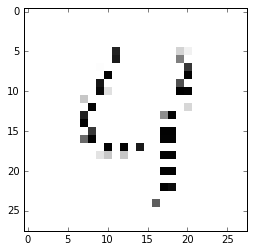

In [64]:
import matplotlib.pyplot as plt
# quick fn to plot images
imshow = lambda img : plt.imshow(1 - img.reshape((28,28)),
                                 cmap='Greys_r',interpolation='nearest')

imshow(x_[4])

In [14]:
x_.shape

(10000, 1, 28, 28)

## Tensorflow unpool & Deconv

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
@ops.RegisterGradient("MaxPoolWithArgmax")
def _MaxPoolWithArgmaxGrad(op, grad, unused_argmax):
  return gen_nn_ops._max_pool_grad(op.inputs[0],
                                   op.outputs[0],
                                   grad,
                                   op.get_attr("ksize"),
                                   op.get_attr("strides"),
                                   padding=op.get_attr("padding"),
                                   data_format=op.get_attr("data_format"))

In [3]:
sess = tf.InteractiveSession()

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# quick fn to plot images
imshow = lambda img : plt.imshow(1 - img.reshape((img.shape[1], img.shape[2])),
                                 cmap='Greys_r',interpolation='nearest')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
BATCH_SIZE = 5
test_img = tf.reshape(mnist.train.next_batch(BATCH_SIZE)[0], [BATCH_SIZE,28,28,1])

filt = tf.Variable(tf.truncated_normal([3,3,1,3], stddev=.1))
filt.initializer.run()
conv = tf.nn.conv2d(test_img, filt, [1,1,1,1] ,'SAME')
deconv = tf.nn.conv2d_transpose(conv, filt, [BATCH_SIZE,28,28,1], [1,1,1,1])

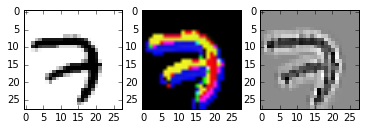

In [6]:
plt.subplot(1,3,1)
imshow(test_img.eval()[0,...].reshape([1,28,28,1]))
plt.subplot(1,3,2)
plt.imshow(conv.eval()[0,...].reshape([28,28,3]))
plt.subplot(1,3,3)
imshow(deconv.eval()[0,...].reshape([1,28,28,1]))

In [13]:
maxpool, argmax = tf.nn.max_pool_with_argmax(conv,
                                             ksize=[1,2,2,1],
                                             strides=[1,2,2,1],
                                            padding='SAME')

In [14]:
maxpool_ = tf.nn.max_pool(conv,
                         ksize=[1,2,2,1],
                         strides=[1,2,2,1],
                        padding='SAME')

In [40]:
grad = tf.gradients(maxpool_, conv)[0] * maxpool_
plt.imshow(grad.eval()[0,...].reshape([28,28,3]))

ValueError: Incompatible shapes for broadcasting: (5, 28, 28, 3) and (5, 14, 14, 3)

In [20]:
maxshape = [s.value for s in maxpool.get_shape()]
offset = tf.cast(28 * 28 * 3, tf.int64)
batch_mul = tf.mul(offset, tf.reshape(tf.cast(tf.range(0,5), tf.int64),[5,1,1,1]))
batch_argmax = tf.add(batch_mul, argmax)
maxflat = tf.reshape(maxpool, [-1])
argflat = tf.reshape(batch_argmax, [-1])
sparse = tf.sparse_to_dense(argflat, [BATCH_SIZE*28*28*3], maxflat, validate_indices=False)
reshaped = tf.reshape(sparse, [-1,28,28,3])

In [21]:
deconv_unpool = tf.nn.conv2d_transpose(reshaped, filt, [BATCH_SIZE,28,28,1], [1,1,1,1])

In [23]:
grad.get_shape().as_list()

[5, 28, 28, 3]

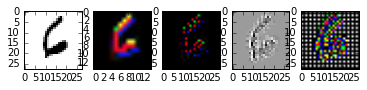

In [24]:
im_n = 3

plt.subplot(1,5,1)
imshow(test_img.eval()[im_n,...].reshape([1,28,28,1]))
plt.subplot(1,5,2)
plt.imshow(maxpool.eval()[im_n,...].reshape([14,14,3]))
plt.subplot(1,5,3)
plt.imshow(reshaped.eval()[im_n,...].reshape([28,28,3]))
plt.subplot(1,5,4)
imshow(deconv_unpool.eval()[im_n,...].reshape([1,28,28,1]))
plt.subplot(1,5,5)
plt.imshow(grad.eval()[im_n,...].reshape([28,28,3]))